## TestCase: Check for the parameter numbers for each 1D-CNN blocks and proceed with deciding their total number

In [134]:
# Importing important packages
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
from keras import layers

- The block above contains three hyperparameter tuning layers for more control over future instances.
- Apart from that, numbers of blocks needed to be implemented is still a long shot.

- Considering the total number of trainable parameters, we need to do some modifications and research to find if the number makes sense.
-  Designing Bi-LSTM layer is not much of a concern since most of the idea of their efficiency is negligible and its worth relying on the trail and error ideology to test which architecture is actually reliable.
- Consider using dropouts:
    - before output fully connected layer.
    - after 1D CNN layer and before the flatten layer in 1D CNN block (if implemented) 
    - after flatten layer in the classification overhead
- Consider using Batch Normalisation layers:
    - After the 1D convolution layer.
- Note: **Avoid using batch normalisation in RNN blocks!**

In [135]:
# create 2 1D CNN blocks -> see learnable parameters

# Input layers
InputLayer = layers.Input(shape=(1000,12))

# 1D-CNN Block 1
conv1d_1 = layers.Conv1D(filters = 32, 
                                kernel_size = 5, # Usual default
                                strides = 1, # Usual default
                                activation = "relu",
                                padding = "same")(InputLayer)
BN_1 = layers.BatchNormalization()(conv1d_1)
MP1d_1 = layers.MaxPool1D(pool_size = 2)(BN_1) # referenced usual default for ptbxl
DropOut_1 = layers.Dropout(0.3)(MP1d_1) # referenced usual default for ptbxl

# 1D-CNN Block 2
conv1d_2 = layers.Conv1D(filters = 64, 
                                kernel_size = 5, # Usual default
                                strides = 1, # Usual default
                                activation = "relu",
                                padding = "same")(DropOut_1)
BN_2 = layers.BatchNormalization()(conv1d_2)
MP1d_2 = layers.MaxPool1D(pool_size = 2)(BN_2) # referenced usual default for ptbxl
DropOut_2 = layers.Dropout(0.3)(MP1d_2)

# 1D-CNN Block 3
conv1d_3 = layers.Conv1D(filters = 128, 
                                kernel_size = 5, # Usual default
                                strides = 1, # Usual default
                                activation = "relu",
                                padding = "same")(DropOut_2)
BN_3 = layers.BatchNormalization()(conv1d_3)
MP1d_3 = layers.MaxPool1D(pool_size = 2)(BN_3) # referenced usual default for ptbxl
DropOut_3 = layers.Dropout(0.3)(MP1d_3)

# Bidirectional LSTM Block 1
Bidirectional_1 = layers.Bidirectional(
    layers.LSTM(64, return_sequences = True))(DropOut_3)

# Bidirectional LSTM Block 2
Bidirectional_2 = layers.Bidirectional(
    layers.LSTM(32))(Bidirectional_1)

# Classification Overhead
Dense_1 = layers.Dense(units = 256,
                      activation = "relu")(Bidirectional_2)
DropOut_Classification_1 = layers.Dropout(0.3)(Dense_1)
Dense_2 = layers.Dense(units = 128,
                      activation = "relu")(DropOut_Classification_1)
DropOut_Classification_2 = layers.Dropout(0.3)(Dense_2)
OutputLayer = layers.Dense(units = 7,# referenced usual default for ptbxl
                              activation = "sigmoid",# referenced usual default for ptbxl
                              )(DropOut_Classification_2)

# Model Creation
model = tf.keras.Model(inputs = InputLayer,
                            outputs = OutputLayer,
                            name = "TestCaseModel_Conv_2_Blocks")

In [136]:
# Subclass Custom Hamming Loss metric (Not using tensorflow addons here; version clash)

class HammingLoss(tf.keras.metrics.Metric):

    def __init__(self, name = "Hamming_loss", **kwargs):
        super(HammingLoss, self).__init__(name = name, **kwargs)
        self.total_mismatches = self.add_weight(name = "Total_mismatches", initializer = 'zeros', dtype = tf.float32)
        self.total_labels = self.add_weight(name = "Total_labels", initializer = 'zeros', dtype = tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # caste predictions and targets in tf.float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)

        # Calculate mismatches
        mismatches = tf.cast((tf.math.count_nonzero(tf.math.not_equal(y_true, y_pred), axis=-1)), tf.float32)

        # Find number of labels and batch size
        num_label = tf.cast(tf.shape(y_true)[-1], tf.float32) # shape is (rows, columns) and columns = number of elements in array
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32) # shape is (rows, columns) and rows = batch size per array
        
        # Update number of mismatches and total labels count
        self.total_mismatches.assign_add(tf.reduce_sum(mismatches)) # reduce sum adds all the elements in an array (here, instance)
        self.total_labels.assign_add(batch_size * num_label) # total label count = number of labels x batch size per instance

    def result(self):
        return self.total_mismatches / self.total_labels # Hamming Loss formula
    
    def reset_state(self): # reset atttributes
        self.total_mismatches.assign(0.)
        self.total_labels.assign(0.)

In [137]:
# Subclass Custom Hamming score metric

class HammingScore(tf.keras.metrics.Metric):

    def __init__(self, name = "Hamming_score", **kwargs):
        super(HammingScore, self).__init__(name = name, **kwargs)
        self.total_mismatches = self.add_weight(name = "Total_mismatches", initializer = 'zeros', dtype = tf.float32)
        self.total_labels = self.add_weight(name = "Total_labels", initializer = 'zeros', dtype = tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # caste predictions and targets in tf.float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)

        # Calculate mismatches
        mismatches = tf.cast((tf.math.count_nonzero(tf.math.not_equal(y_true, y_pred), axis=-1)), tf.float32)

        # Find number of labels and batch size
        num_label = tf.cast(tf.shape(y_true)[-1], tf.float32) # shape is (rows, columns) and columns = number of elements in array
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32) # shape is (rows, columns) and rows = batch size per array
        
        # Update number of mismatches and total labels count
        self.total_mismatches.assign_add(tf.reduce_sum(mismatches)) # reduce sum adds all the elements in an array (here, instance)
        self.total_labels.assign_add(batch_size * num_label) # total label count = number of labels x batch size per instance

    def result(self):
        return 1 - (self.total_mismatches / self.total_labels) # Hamming Score = 1 - Hamming loss
    
    def reset_state(self): # reset atttributes
        self.total_mismatches.assign(0.)
        self.total_labels.assign(0.)

In [138]:

# Model Compilation (loss function and optimiser) 
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.binary_focal_crossentropy,
              metrics = [tf.keras.metrics.AUC(curve = "ROC", name = "ROC-AUC"),
                         tf.keras.metrics.Recall(name = "recall", thresholds = 0.35),
                         tf.keras.metrics.Precision(name = "precision"),
                         tf.keras.metrics.FBetaScore(beta = 2.0, average = "weighted", threshold = 0.35),
                         tf.keras.metrics.AUC(curve = "PR", name = "PR-AUC"),
                         tf.keras.metrics.BinaryAccuracy,
                         HammingLoss(),
                         HammingScore()])

In [139]:
model.summary()

Model: "TestCaseModel_Conv_2_Blocks"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 1000, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 1000, 32)       │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 1000, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 500, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 500, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 500, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 250, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 250, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 125, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 125, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 125, 128)       │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,711 (955.90 KB)

 Trainable params: 244,263 (954.15 KB)

 Non-trainable params: 448 (1.75 KB)

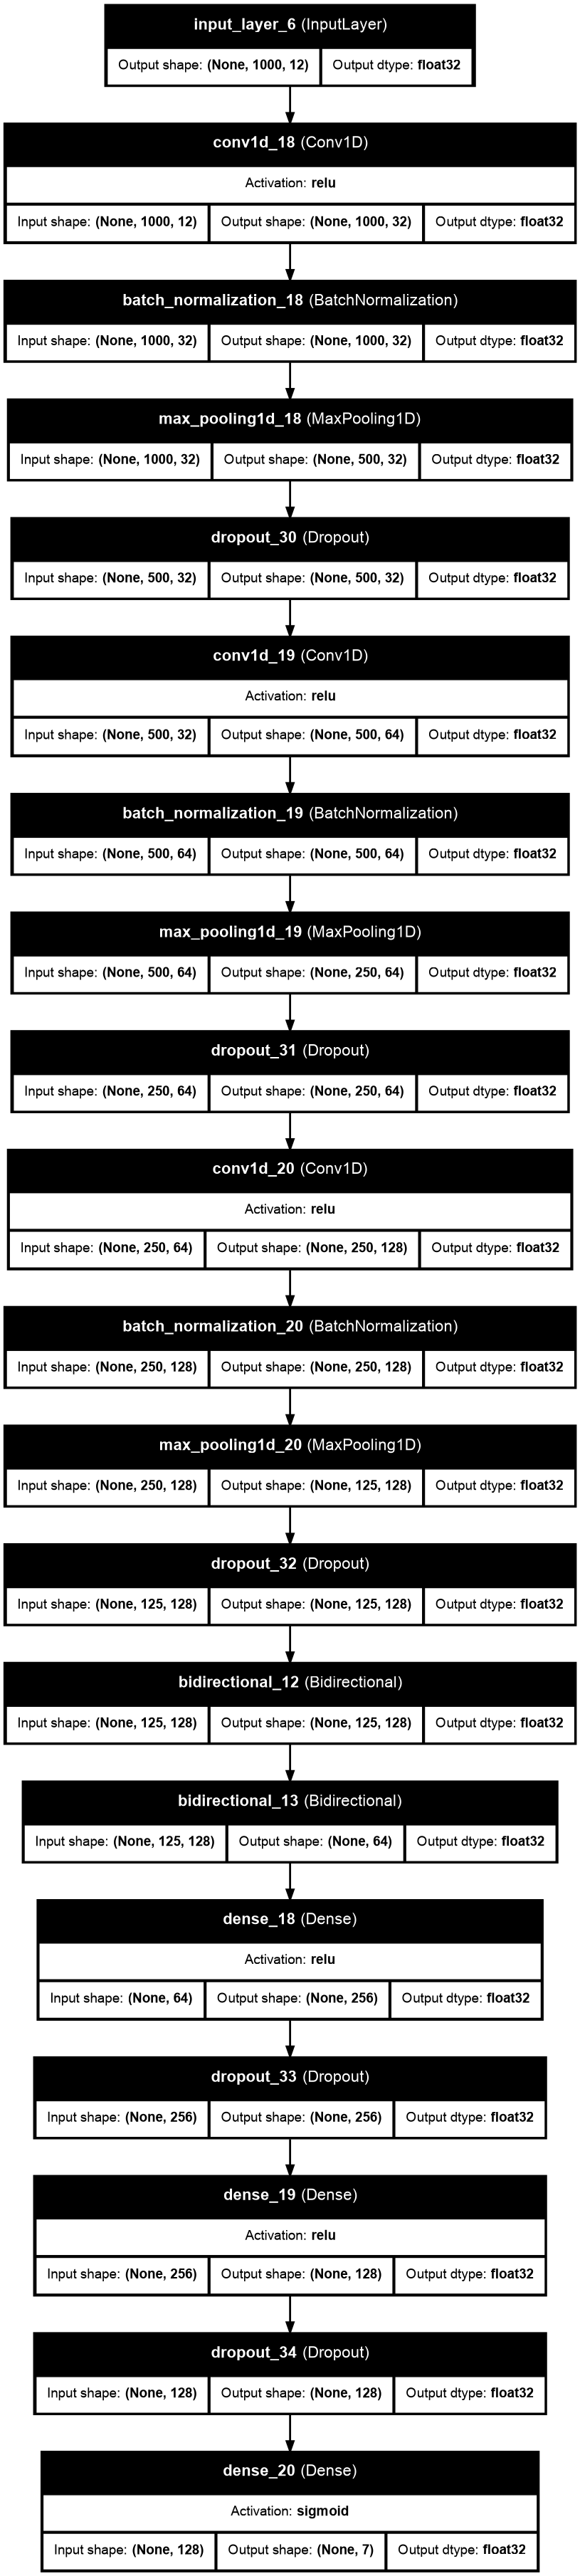

In [140]:
# Visualise The Model

tf.keras.utils.plot_model(model,
                          dpi = 100,
                          to_file = 'Final.png',
                          show_shapes = True,
                          show_dtype = True,
                          show_layer_names = True,
                          show_layer_activations = True)

## De-pickling training data

In [141]:
# load train dependant vars
with open("/home/student/Prathamesh's Project Pre-requisites/CodeSpace/DL/CheckPoint1/X_TRAIN.pkl", "rb") as f:
    x_train = pickle.load(f)

In [142]:
# load train target vars
with open("/home/student/Prathamesh's Project Pre-requisites/CodeSpace/DL/CheckPoint1/Y_TRAIN.pkl", "rb") as f:
    y_train = pickle.load(f)

In [143]:
# Check the data
print(f"The shape of dependent variables is {x_train.shape}.")
print(f"The shape of independent variables is {y_train.shape}.")

The shape of dependent variables is (12123, 1000, 12).
The shape of independent variables is (12123,).


In [144]:
# load test dependant vars
with open("/home/student/Prathamesh's Project Pre-requisites/CodeSpace/DL/CheckPoint1/X_TEST.pkl", "rb") as f:
    x_test = pickle.load(f)

In [145]:
# load test target vars
with open("/home/student/Prathamesh's Project Pre-requisites/CodeSpace/DL/CheckPoint1/Y_TEST.pkl", "rb") as f:
    y_test = pickle.load(f)

In [146]:
# load val dependant vars
with open("/home/student/Prathamesh's Project Pre-requisites/CodeSpace/DL/CheckPoint2/X_VAL.pkl", "rb") as f:
    x_val = pickle.load(f)

In [147]:
# load val target vars
with open("/home/student/Prathamesh's Project Pre-requisites/CodeSpace/DL/CheckPoint2/Y_VAL.pkl", "rb") as f:
    y_val = pickle.load(f)

In [148]:
# Check the data
print(f"The shape of dependent variables is {x_test.shape}.")
print(f"The shape of independent variables is {y_test.shape}.")

The shape of dependent variables is (1512, 1000, 12).
The shape of independent variables is (1512,).


The data seems to be correctly loaded!

## Trial Training Session

In [149]:
# x trial batch prep
trial_x_train = tf.cast(x_train, dtype=tf.float32) # for converting the numpy arrays into tensors of float32
print(f"the length for the both must be {len(trial_x_train)}")

# testing data preprocessing
trial_x_test = tf.cast(x_test, dtype = tf.float32)

# val data preprocessing
trial_x_val = tf.cast(x_val, dtype = tf.float32)
print(f"The datatype for the testing signal data is {type(trial_x_test)}")
print(f"\nLet us see the first entry:\n {trial_x_test[1]}")
print(f"\nTotal number of signals obtained from patients: {len(trial_x_test)}")

the length for the both must be 12123
The datatype for the testing signal data is <class 'tensorflow.python.framework.ops.EagerTensor'>

Let us see the first entry:
 [[ 0.00809643  0.02118633  0.01307777 ... -0.00297517 -0.00599571
  -0.00397102]
 [ 0.02310487  0.02193361 -0.00116536 ... -0.00250275 -0.00507634
  -0.00340584]
 [ 0.02422108  0.02496292  0.0006977  ... -0.00265434 -0.00244668
  -0.00100723]
 ...
 [ 0.26132208  0.26762414  0.00544839 ...  0.03903596  0.08776658
   0.02479506]
 [ 0.23355836  0.23503971  0.00150268 ...  0.03900548 -0.02465511
   0.0219655 ]
 [ 0.02392498  0.01611293 -0.00769422 ...  0.02712256  0.02170888
   0.01636948]]

Total number of signals obtained from patients: 1512


**Considerations for target variables**

- Convert these pandas series into list.
- Setting up string lookup layer
- Setting up adapt layer (to create adapted vocabulary)
- Convert it

In [150]:
# analyse dtype of y_train
print(f"The data type of train target variables is {type(y_train)}")
print(f"The data type of test target variables is {type(y_test)}")

The data type of train target variables is <class 'pandas.core.series.Series'>
The data type of test target variables is <class 'pandas.core.series.Series'>


In [151]:
# convert into list
y_train = y_train.to_list()
y_test = y_test.to_list()
print(f"The data type of train target variables is {type(y_train)}")
print(f"The data type of test target variables is {type(y_test)}")

The data type of train target variables is <class 'list'>
The data type of test target variables is <class 'list'>


In [152]:
# Analyse
print(y_train[1:10])
print(y_test[1:10])

[['NORM'], ['NORM'], ['NORM'], ['NORM'], ['NORM'], ['NORM'], ['STTC'], ['NORM'], ['NORM']]
[['NORM'], ['CD'], ['NORM'], ['NORM'], ['NORM'], ['NORM'], ['NORM'], ['CD'], ['STTC']]


In [153]:
# y trail batch split
trial_y_train = y_train
print(f"the length for the both must be {len(trial_y_train)}")
trial_y_test = y_test
print(f"the length for the both must be {len(trial_y_test)}")
trial_y_val = y_val
print(f"the length for the both must be {len(trial_y_val)}")

the length for the both must be 12123
the length for the both must be 1512
the length for the both must be 1484


In [154]:
# convert the list into a ragged tensor (handles non-rectangular data)
ragged_target_variable_train = tf.ragged.constant(trial_y_train)
ragged_target_variable_test = tf.ragged.constant(trial_y_test)
ragged_target_variable_val = tf.ragged.constant(trial_y_val)

In [155]:
# String Lookup layer
Str_Lookup_layer = layers.StringLookup(output_mode="multi_hot")
Str_Lookup_layer.adapt(ragged_target_variable_train)
Str_Lookup_layer.get_vocabulary() # see the vocab

['[UNK]',
 np.str_('NORM'),
 np.str_('MI'),
 np.str_('STTC'),
 np.str_('CD'),
 np.str_('HYP'),
 np.str_('HYP_HR')]

In [156]:
# Get the final converted form
trial_y_train = Str_Lookup_layer(ragged_target_variable_train)
trial_y_test = Str_Lookup_layer(ragged_target_variable_test)
trial_y_val = Str_Lookup_layer(ragged_target_variable_val)

In [157]:
trial_y_train = tf.cast(trial_y_train, tf.float32)
trial_y_test = tf.cast(trial_y_test, tf.float32)
trial_y_val = tf.cast(trial_y_val, tf.float32)

In [158]:
# test the first entry
print(trial_y_train[7]) # STTC entry
print(trial_y_test[7]) # NORM entry

tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)


**Notes**

For Epochs:

- small dataset (<10k>) : epochs = 10-50
- medium dataset (10k-100k) : epochs = 20-200
- large datsets (100k+) : epochs = 50-500+
- fine-tuning/pre-trained models : epochs = 3-10

For batch size: (& ^gradient estimate stability & ^convergence & !Generaliastion)

- standard/baseline = 32
- Image Classification  = 32/64/128
- NLP = ~16-32
- Limited Memory/Small dataset = 8/16

In [159]:
# Data is imbalanced - go for weighted training
# Define function to compute class weight

def ComputeClassWeights(y_train):
    num_samples = len(y_train)
    num_classes = y_train.shape[1]

    class_weight = {}
    for i in range(num_classes):
        pos = np.sum(y_train[:, i])
        neg = num_samples - pos

        if pos > 0:
            weight = neg / pos
            class_weight[i] = min(weight, 10.0)
        else:
            class_weight[i] = 1.0

    
    print(f"Class weigths: ")
    for i, weight in class_weight.items():
        pos_ratio = np.sum(y_train[:,i])/len(y_train) * 100
        print(f"class {i} : {weight:.2f} (prevalence : {pos_ratio:.1f}%)")

    return class_weight        

In [160]:
# Apply class weights

current_class_weights = ComputeClassWeights(trial_y_train)

Class weigths: 
class 0 : 1.00 (prevalence : 0.0%)
class 1 : 1.11 (prevalence : 47.4%)
class 2 : 3.27 (prevalence : 23.4%)
class 3 : 3.30 (prevalence : 23.2%)
class 4 : 3.51 (prevalence : 22.2%)
class 5 : 10.00 (prevalence : 8.1%)
class 6 : 10.00 (prevalence : 4.3%)


In [161]:
# Set call backs

Callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = "val_precision", patience = 12, restore_best_weights = True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 5)
]

In [162]:
# train the model

History = model.fit(
    x = trial_x_train,
    y = trial_y_train,
    validation_data = (trial_x_val, trial_y_val),
    epochs = 100,
    batch_size = 64,
    callbacks = Callbacks
)

Epoch 1/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - Hamming_loss: 0.1891 - Hamming_score: 0.8109 - PR-AUC: 0.3626 - ROC-AUC: 0.7476 - binary_accuracy: 0.8109 - fbeta_score: 0.6056 - loss: 0.1076 - precision: 0.4560 - recall: 0.8315 - val_Hamming_loss: 0.1824 - val_Hamming_score: 0.8176 - val_PR-AUC: 0.3789 - val_ROC-AUC: 0.7695 - val_binary_accuracy: 0.8176 - val_fbeta_score: 0.6160 - val_loss: 0.1028 - val_precision: 0.5667 - val_recall: 0.8731 - learning_rate: 0.0010
Epoch 2/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - Hamming_loss: 0.1856 - Hamming_score: 0.8144 - PR-AUC: 0.3801 - ROC-AUC: 0.7621 - binary_accuracy: 0.8144 - fbeta_score: 0.6139 - loss: 0.1041 - precision: 0.4796 - recall: 0.8686 - val_Hamming_loss: 0.1829 - val_Hamming_score: 0.8171 - val_PR-AUC: 0.3934 - val_ROC-AUC: 0.7742 - val_binary_accuracy: 0.8171 - val_fbeta_score: 0.6210 - val_loss: 0.1013 - val_precision: 0.4967 - val_recall: 0.9042 - learning_rate: 0.0010
Epoch 3/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1

In [163]:
# evaluate the model
Evaluation_result = model.evaluate(
    x = trial_x_test,
    y = trial_y_test,
    batch_size = 32   
)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - Hamming_loss: 0.1834 - Hamming_score: 0.8166 - PR-AUC: 0.3853 - ROC-AUC: 0.7674 - binary_accuracy: 0.8166 - fbeta_score: 0.6218 - loss: 0.1028 - precision: 0.6667 - recall: 0.9043


In [164]:
results = model.predict(x = trial_x_test[99:100])
print(results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
[[0.12200408 0.48344892 0.40426013 0.3990733  0.37570134 0.3088913
  0.25658005]]


> Results: **The test run was successful. Now we will adapt this pipeline to our cloud instance.**